<a href="https://colab.research.google.com/github/seonjing/Advanced_Machine_Learning_8team/blob/main/2024711247_%EA%B9%80%EC%9E%AC%EC%9D%80_ExchangeRate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install xgboost
import sys, glob
import time
from datetime import timedelta, date
from os.path import *
import psycopg2
import json
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from itertools import product

In [ ]:
from google.colab import files

# 파일 업로드
uploaded = files.upload()

Saving 241204_exchange_raw_fin.txt to 241204_exchange_raw_fin.txt


In [ ]:
# 업로드된 파일 확인
for filename in uploaded.keys():
    print(f"Uploaded file: {filename}")

Uploaded file: 241204_exchange_raw_fin.txt


In [ ]:
# 1. 데이터불러오기
##################################################################
# a. 수집변수목록 : 날짜별 환율(exchange_rate), 코스피(kospi), 경제성장률(growth_rate), 연방금리(federal_rate), 물가지수(cpi_index), 다우(dow), 나스닥(nasdaq), 원유(crude_oil), 자본수지한(capital_index_korea), 자본수지미(capital_index_us)
#.b. 전처리 : 최소·최대 정규화 기법을 활용하여 변수들의 범위를 0과1사이의 실수 값으로 변환 → 데이터 improt 전 처리
##################################################################
df = pd.read_csv('241204_exchange_raw_fin.txt', delimiter='\t', encoding='utf-8')
print(df.head())
print(df.describe())

         date  exchange_rate     kospi  growth_rate  federal_rate  cpi_index  \
0  2010-01-04       0.628266  0.652816          1.0           0.0        0.0   
1  2010-01-05       0.583135  0.650691          1.0           0.0        0.0   
2  2010-01-06       0.536025  0.656349          1.0           0.0        0.0   
3  2010-01-07       0.511876  0.647932          1.0           0.0        0.0   
4  2010-01-08       0.492082  0.652477          1.0           0.0        0.0   

        dow    nasdaq  crude_oil  capital_index_korea  capital_index_us  
0  0.369484  0.255855   0.602231             0.116165          0.760234  
1  0.369067  0.255887   0.602231             0.116165          0.760234  
2  0.369125  0.255042   0.602231             0.116165          0.760234  
3  0.370283  0.254927   0.602231             0.116165          0.760234  
4  0.370679  0.256824   0.602231             0.116165          0.760234  
       exchange_rate        kospi  growth_rate  federal_rate    cpi_index  

In [ ]:
# 2. 데이터 스플릿
##################################################################
# a. 날짜변수인 date를 날짜형으로 변경한 후 train, valid, test data로 분할
# b. 환율column을 타겟으로, 그 외 column을 피쳐로 저장
##################################################################

df['date'] = pd.to_datetime(df['date'])

train_data = df[(df['date'] >= '2010-01-01') & (df['date'] <= '2016-12-31')]
valid_data = df[(df['date'] >= '2017-01-01') & (df['date'] <= '2018-12-31')]
test_data = df[(df['date'] >= '2019-01-01') & (df['date'] <= '2019-12-31')]

feature_columns = ['kospi', 'growth_rate', 'federal_rate', 'cpi_index', 'dow', 'nasdaq', 'crude_oil', 'capital_index_korea', 'capital_index_us']
target_column = 'exchange_rate'

# X_train, y_train = train_data[feature_columns], train_data[target_column]
# X_valid, y_valid = valid_data[feature_columns], valid_data[target_column]
# X_test, y_test = test_data[feature_columns], test_data[target_column]

In [ ]:
# 3. 데이터 전처리 & 논문형태로 모델링
##################################################################
# a. 전처리1 : 파생변수 추가 : 이동평균 추가(기준일 이전 7일 이동 평균), 과거 1일~7일 데이터 추가
# b. 전처리2: 결측치를 0으로 대체
# c. 모델링 : XGBoost 사용, 주어진 하이퍼파라미터 설정
# d. 논문성능 유사구현성공 : mae기준 논문발표 성능 : 0.0163, 구현성능 : 0.0182
##################################################################

# Feature Engineering: 이동 평균 및 과거 7일간의 환율 값 추가
def add_lag_features(data, target_column, lag_days=7):
    """
    데이터에 이동 평균 및 과거 N일간의 타겟 변수 값을 추가하는 함수.

    Args:
        data (pd.DataFrame): 입력 데이터 (date 컬럼 포함 필요)
        target_column (str): 타겟 변수 이름
        lag_days (int): 과거 값 추가 범위 (예: 7일)

    Returns:
        pd.DataFrame: 이동 평균 및 과거 값을 포함한 데이터프레임
    """
    data = data.copy()
    data = data.sort_values(by="date")
    # 7일 이동 평균 추가
    data[f"{target_column}_7d_avg"] = data[target_column].rolling(window=7).mean()
    # 과거 1일~7일 데이터 추가
    for lag in range(1, lag_days + 1):
        data[f"{target_column}_lag_{lag}"] = data[target_column].shift(lag)
    # 결측치를 0으로 대체
    data.fillna(0, inplace=True)
    return data

# --- 데이터 준비 ---
# Feature Engineering을 적용하여 train_data와 test_data를 변환
train_data = add_lag_features(train_data, target_column='exchange_rate', lag_days=7)
test_data = add_lag_features(test_data, target_column='exchange_rate', lag_days=7)

# 사용될 피처 컬럼 정의 (기존 피처 + 새로 생성된 이동 평균 및 lag 변수)
feature_columns = [
    'kospi', 'growth_rate', 'federal_rate', 'cpi_index', 'dow', 'nasdaq', 'crude_oil',
    'capital_index_korea', 'capital_index_us',
    'exchange_rate_7d_avg',  # 7일 이동 평균
    'exchange_rate_lag_1', 'exchange_rate_lag_2', 'exchange_rate_lag_3',
    'exchange_rate_lag_4', 'exchange_rate_lag_5', 'exchange_rate_lag_6',
    'exchange_rate_lag_7'   # 과거 1~7일 데이터
]

# 학습 데이터 (train_data)와 테스트 데이터 (test_data) 분리
X_train = train_data[feature_columns]  # 학습 피처
y_train = train_data['exchange_rate']  # 학습 타겟 변수
X_test = test_data[feature_columns]    # 테스트 피처
y_test = test_data['exchange_rate']    # 테스트 타겟 변수

# --- XGBoost 하이퍼파라미터 설정 ---
xgb_params = {
    'learning_rate': 0.07,  # 학습 속도
    'max_depth': 7,  # 의사결정 나무의 최대 깊이
    'n_estimators': 300,  # 부스팅 반복 횟수
    'subsample': 0.6,  # 각 트리 학습에 사용할 샘플 비율
    'colsample_bytree': 0.4,  # 각 트리 학습에 사용할 피처 비율
    'silent': 1,  # 출력 로그를 최소화
    'min_child_weight': 4,  # 리프 노드에 필요한 최소 샘플 가중치
    'nthread': 4,  # 사용 가능한 스레드 수
    'objective': 'reg:squarederror'  # 회귀 문제를 위한 손실 함수
}

# --- 모델 학습 및 평가 ---
print("\n모델 학습 및 테스트 데이터로 최종 성능 평가 시작...")

# XGBoost Regressor 모델 생성
model = xgb.XGBRegressor(**xgb_params)

# 모델 학습 (train_data를 사용)
model.fit(X_train, y_train)

# 테스트 데이터에서 성능 평가
y_test_pred = model.predict(X_test)  # 테스트 데이터 예측
mae_test = mean_absolute_error(y_test, y_test_pred)  # 평균 절대 오차 (MAE)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))  # 평균 제곱근 오차 (RMSE)
r2_test = r2_score(y_test, y_test_pred)  # R-squared (설명력)

# 성능 출력
print(f"테스트 데이터 성능:")
print(f"MAE: {mae_test:.4f}, RMSE: {rmse_test:.4f}, R²: {r2_test:.4f}")



모델 학습 및 테스트 데이터로 최종 성능 평가 시작...


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:02:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


테스트 데이터 성능:
MAE: 0.0182, RMSE: 0.0310, R²: 0.9277


In [ ]:
train_data.head()

,date,exchange_rate,kospi,growth_rate,federal_rate,cpi_index,dow,nasdaq,crude_oil,capital_index_korea,capital_index_us,exchange_rate_7d_avg,exchange_rate_lag_1,exchange_rate_lag_2,exchange_rate_lag_3,exchange_rate_lag_4,exchange_rate_lag_5,exchange_rate_lag_6,exchange_rate_lag_7
0,2010-01-04,0.628266,0.652816,1.0,0.0,0.0,0.369484,0.255855,0.602231,0.116165,0.760234,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
1,2010-01-05,0.583135,0.650691,1.0,0.0,0.0,0.369067,0.255887,0.602231,0.116165,0.760234,0.0,0.628266,0.000000,0.000000,0.000000,0.0,0.0,0.0
2,2010-01-06,0.536025,0.656349,1.0,0.0,0.0,0.369125,0.255042,0.602231,0.116165,0.760234,0.0,0.583135,0.628266,0.000000,0.000000,0.0,0.0,0.0
3,2010-01-07,0.511876,0.647932,1.0,0.0,0.0,0.370283,0.254927,0.602231,0.116165,0.760234,0.0,0.536025,0.583135,0.628266,0.000000,0.0,0.0,0.0
4,2010-01-08,0.492082,0.652477,1.0,0.0,0.0,0.370679,0.256824,0.602231,0.116165,0.760234,0.0,0.511876,0.536025,0.583135,0.628266,0.0,0.0,0.0


In [ ]:
# 4. 성능향상을 위한 모델링
##################################################################
# a. 논문에서는 XGBoost 단일모델로 구현하였으나, LSTM과의 앙상블을 통한 성능 향상을 이룸
# b. 블렌딩 가중치 최적화를  Grid Search 실행
# c. 그 결과 최적 가중치: XGBoost=0.90, LSTM=0.10을 기준하여  블렌딩 모델 최적 테스트,  데이터 성능: MAE: 0.0154
# d. 논문성능 상회 구현성공 : mae기준 논문발표 성능 : 0.0163, 구현성능 : 0.0154
# e. sequence_length(5), Dropout(0.2), lstm layer(2), epochs(50), batch_size(32) 등 하이퍼파라미터는 데이터 건수 등의 고려하여 test 후 설정함
##################################################################

# --- Feature Engineering ---
def add_lag_features(data, target_column, lag_days=7):
    """
    이동 평균 및 과거 값(lagged values)을 데이터에 추가하는 함수.

    Args:
        data (pd.DataFrame): 입력 데이터
        target_column (str): 타겟 변수 이름 (예: 'exchange_rate')
        lag_days (int): 과거 데이터 범위 (예: 7일)

    Returns:
        pd.DataFrame: 변환된 데이터프레임 (lag 및 이동 평균 포함)
    """
    data = data.copy()  # 원본 데이터 보호
    data = data.sort_values(by="date")  # 날짜 순 정렬
    # 7일 이동 평균 추가
    data[f"{target_column}_7d_avg"] = data[target_column].rolling(window=7).mean()
    # 과거 1일~7일 데이터 추가
    for lag in range(1, lag_days + 1):
        data[f"{target_column}_lag_{lag}"] = data[target_column].shift(lag)
    # 결측치를 제거하고 인덱스를 리셋
    return data.dropna().reset_index(drop=True)

# Feature Engineering 적용: train_data와 test_data 변환
train_data = add_lag_features(train_data, target_column='exchange_rate', lag_days=7)
test_data = add_lag_features(test_data, target_column='exchange_rate', lag_days=7)

# 모델 학습에 사용할 피처 정의
feature_columns = [
    'kospi', 'growth_rate', 'federal_rate', 'cpi_index', 'dow', 'nasdaq', 'crude_oil',
    'capital_index_korea', 'capital_index_us',
    'exchange_rate_7d_avg', 'exchange_rate_lag_1', 'exchange_rate_lag_2',
    'exchange_rate_lag_3', 'exchange_rate_lag_4', 'exchange_rate_lag_5',
    'exchange_rate_lag_6', 'exchange_rate_lag_7'
]

# 학습 데이터와 테스트 데이터 분리
X_train = train_data[feature_columns]
y_train = train_data['exchange_rate']
X_test = test_data[feature_columns]
y_test = test_data['exchange_rate']

# --- 데이터 정규화 ---
# LSTM 모델에 적합하도록 데이터를 MinMaxScaler로 정규화
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- LSTM 데이터 준비 ---
def create_sequences(data, target, sequence_length=5):
    """
    시계열 데이터를 LSTM 모델 입력 형식(3D 텐서)으로 변환하는 함수.

    Args:
        data (np.array): 정규화된 입력 데이터
        target (np.array): 타겟 변수 데이터
        sequence_length (int): 입력 시퀀스 길이 (예: 5)

    Returns:
        tuple: (X, y) 형태의 시퀀스 데이터
    """
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i])  # 과거 `sequence_length` 길이만큼의 데이터
        y.append(target[i])  # 해당 시점의 타겟값
    return np.array(X), np.array(y)

# 시퀀스 길이를 5로 설정하여 LSTM 입력 데이터 생성
sequence_length = 5
X_train_lstm, y_train_lstm = create_sequences(X_train_scaled, y_train.values, sequence_length)
X_test_lstm, y_test_lstm = create_sequences(X_test_scaled, y_test.values, sequence_length)

# --- LSTM 모델 ---
# 모델 구조: 두 개의 LSTM 레이어와 Dropout 추가
lstm_model = Sequential([
    LSTM(64, activation='relu', return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dropout(0.3),  # 과적합 방지
    LSTM(32, activation='relu', return_sequences=False),
    Dropout(0.3),  # 추가 Dropout
    Dense(1)  # 출력층: 단일 값
])

# LSTM 모델 컴파일 및 학습
lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')  # 학습률=0.001
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=32, verbose=1)  # 에포크=50, 배치 크기=32
y_train_pred_lstm = lstm_model.predict(X_train_lstm).flatten()  # 학습 데이터 예측
y_test_pred_lstm = lstm_model.predict(X_test_lstm).flatten()  # 테스트 데이터 예측

# --- XGBoost 모델 ---
# 하이퍼파라미터 설정
xgb_params = {
    'learning_rate': 0.07,
    'max_depth': 7,
    'n_estimators': 300,
    'subsample': 0.6,
    'colsample_bytree': 0.4,
    'silent': 1,
    'min_child_weight': 4,
    'nthread': 4,
    'objective': 'reg:squarederror'
}

# XGBoost 모델 학습
xgb_model = xgb.XGBRegressor(**xgb_params)
xgb_model.fit(X_train, y_train)  # 학습
y_train_pred_xgb = xgb_model.predict(X_train)  # 학습 데이터 예측
y_test_pred_xgb = xgb_model.predict(X_test)  # 테스트 데이터 예측

# --- Grid Search: 블렌딩 가중치 최적화 ---
# 블렌딩 가중치를 탐색 (0.0 ~ 1.0 사이의 11개 후보)
weight_candidates = np.linspace(0, 1, 11)
best_mae = float("inf")
best_weights = (0, 0)

# 모든 가중치 조합(product) 반복
for weight_xgb, weight_lstm in product(weight_candidates, repeat=2):
    if abs(weight_xgb + weight_lstm - 1) > 1e-5:  # 가중치 합이 1이 아닌 경우 무시
        continue
    # 블렌딩 예측값 계산
    y_test_pred_blend = (
        weight_xgb * y_test_pred_xgb[sequence_length:]
        + weight_lstm * y_test_pred_lstm
    )
    # MAE 계산
    mae = mean_absolute_error(y_test[sequence_length:], y_test_pred_blend)
    if mae < best_mae:  # MAE가 개선되면 최적 가중치 업데이트
        best_mae = mae
        best_weights = (weight_xgb, weight_lstm)

# --- 최적 가중치로 블렌딩 ---
best_weight_xgb, best_weight_lstm = best_weights
y_test_pred_best_blend = (
    best_weight_xgb * y_test_pred_xgb[sequence_length:]
    + best_weight_lstm * y_test_pred_lstm
)

# --- 최종 성능 평가 ---
mae_test = mean_absolute_error(y_test[sequence_length:], y_test_pred_best_blend)
rmse_test = np.sqrt(mean_squared_error(y_test[sequence_length:], y_test_pred_best_blend))
r2_test = r2_score(y_test[sequence_length:], y_test_pred_best_blend)

print(f"최적 가중치: XGBoost={best_weight_xgb:.2f}, LSTM={best_weight_lstm:.2f}")
print(f"블렌딩 모델 최적 테스트 데이터 성능:")
print(f"MAE: {mae_test:.4f}, RMSE: {rmse_test:.4f}, R²: {r2_test:.4f}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0601
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0118
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0120
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0083
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0082
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0074
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0081
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0075
Epoch 9/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0067
Epoch 10/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0069
Epoch 11/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0057
Epoch 12/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0057
Epoch 13/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0052
Epoch 14/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0054
Epoch 15/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0053
Epoch 16/50
54/54

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:08:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


최적 가중치: XGBoost=0.90, LSTM=0.10
블렌딩 모델 최적 테스트 데이터 성능:
MAE: 0.0153, RMSE: 0.0201, R²: 0.9627


In [ ]:
# 5. 최적화
##################################################################
# Grid Search: 블렌딩 가중치 최적화
# 블렌딩 가중치를 탐색 (0.0 ~ 1.0 사이의 11개 후보)
##################################################################

weight_candidates = np.linspace(0, 1, 11)  # 가중치 후보 생성
best_mae = float("inf")  # 초기값
best_weights = (0, 0)  # 초기 최적 가중치
results = []  # 모든 조합 결과 저장 리스트

# 모든 가중치 조합(product) 반복
for weight_xgb, weight_lstm in product(weight_candidates, repeat=2):
    if abs(weight_xgb + weight_lstm - 1) > 1e-5:  # 가중치 합이 1이 아닌 경우 무시
        continue

    # 블렌딩 예측값 계산
    y_test_pred_blend = (
        weight_xgb * y_test_pred_xgb[sequence_length:]
        + weight_lstm * y_test_pred_lstm
    )

    # 성능 평가
    mae = mean_absolute_error(y_test[sequence_length:], y_test_pred_blend)
    rmse = np.sqrt(mean_squared_error(y_test[sequence_length:], y_test_pred_blend))
    r2 = r2_score(y_test[sequence_length:], y_test_pred_blend)

    # 결과 저장
    results.append({
        "weight_xgb": weight_xgb,
        "weight_lstm": weight_lstm,
        "MAE": mae,
        "RMSE": rmse,
        "R²": r2
    })

    # 최적 성능 갱신
    if mae < best_mae:  # MAE가 개선되면 최적 가중치 업데이트
        best_mae = mae
        best_weights = (weight_xgb, weight_lstm)

# --- 최적 가중치로 블렌딩 ---
best_weight_xgb, best_weight_lstm = best_weights
y_test_pred_best_blend = (
    best_weight_xgb * y_test_pred_xgb[sequence_length:]
    + best_weight_lstm * y_test_pred_lstm
)

# --- 최종 성능 평가 ---
mae_test = mean_absolute_error(y_test[sequence_length:], y_test_pred_best_blend)
rmse_test = np.sqrt(mean_squared_error(y_test[sequence_length:], y_test_pred_best_blend))
r2_test = r2_score(y_test[sequence_length:], y_test_pred_best_blend)

# --- 결과 출력 ---
# 최적 성능 출력
print(f"최적 가중치: XGBoost={best_weight_xgb:.2f}, LSTM={best_weight_lstm:.2f}")
print(f"블렌딩 모델 최적 테스트 데이터 성능:")
print(f"MAE: {mae_test:.4f}, RMSE: {rmse_test:.4f}, R²: {r2_test:.4f}")

# 모든 조합 결과 출력
print("\n--- 모든 가중치 조합 결과 ---")
for result in results:
    print(f"XGBoost: {result['weight_xgb']:.2f}, LSTM: {result['weight_lstm']:.2f}, "
          f"MAE: {result['MAE']:.4f}, RMSE: {result['RMSE']:.4f}, R²: {result['R²']:.4f}")

# --- 결과를 DataFrame으로 저장 ---
# 결과를 DataFrame으로 변환 (필요 시 CSV 파일로 저장 가능)
results_df = pd.DataFrame(results)
print("\n--- 결과 DataFrame ---")
print(results_df)


최적 가중치: XGBoost=0.90, LSTM=0.10
블렌딩 모델 최적 테스트 데이터 성능:
MAE: 0.0153, RMSE: 0.0201, R²: 0.9627

--- 모든 가중치 조합 결과 ---
XGBoost: 0.00, LSTM: 1.00, MAE: 0.0571, RMSE: 0.0696, R²: 0.5505
XGBoost: 0.10, LSTM: 0.90, MAE: 0.0515, RMSE: 0.0629, R²: 0.6332
XGBoost: 0.20, LSTM: 0.80, MAE: 0.0461, RMSE: 0.0562, R²: 0.7067
XGBoost: 0.30, LSTM: 0.70, MAE: 0.0407, RMSE: 0.0497, R²: 0.7710
XGBoost: 0.40, LSTM: 0.60, MAE: 0.0354, RMSE: 0.0433, R²: 0.8261
XGBoost: 0.50, LSTM: 0.50, MAE: 0.0301, RMSE: 0.0372, R²: 0.8719
XGBoost: 0.60, LSTM: 0.40, MAE: 0.0252, RMSE: 0.0314, R²: 0.9084
XGBoost: 0.70, LSTM: 0.30, MAE: 0.0208, RMSE: 0.0263, R²: 0.9357
XGBoost: 0.80, LSTM: 0.20, MAE: 0.0173, RMSE: 0.0223, R²: 0.9538
XGBoost: 0.90, LSTM: 0.10, MAE: 0.0153, RMSE: 0.0201, R²: 0.9627
XGBoost: 1.00, LSTM: 0.00, MAE: 0.0154, RMSE: 0.0202, R²: 0.9623

--- 결과 DataFrame ---
    weight_xgb  weight_lstm       MAE      RMSE        R²
0          0.0          1.0  0.057089  0.069601  0.550462
1          0.1          0.9  0.05

<ipython-input-19-c4b8b65f694a>:27: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from current font.
  plt.tight_layout()
<ipython-input-19-c4b8b65f694a>:27: UserWarning: Glyph 45944 (\N{HANGUL SYLLABLE DEL}) missing from current font.
  plt.tight_layout()
<ipython-input-19-c4b8b65f694a>:27: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from current font.
  plt.tight_layout()
<ipython-input-19-c4b8b65f694a>:27: UserWarning: Glyph 44368 (\N{HANGUL SYLLABLE GYO}) missing from current font.
  plt.tight_layout()
<ipython-input-19-c4b8b65f694a>:27: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  plt.tight_layout()
<ipython-input-19-c4b8b65f694a>:27: UserWarning: Glyph 44033 (\N{HANGUL SYLLABLE GAG}) missing from current font.
  plt.tight_layout()
<ipython-input-19-c4b8b65f694a>:27: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylab

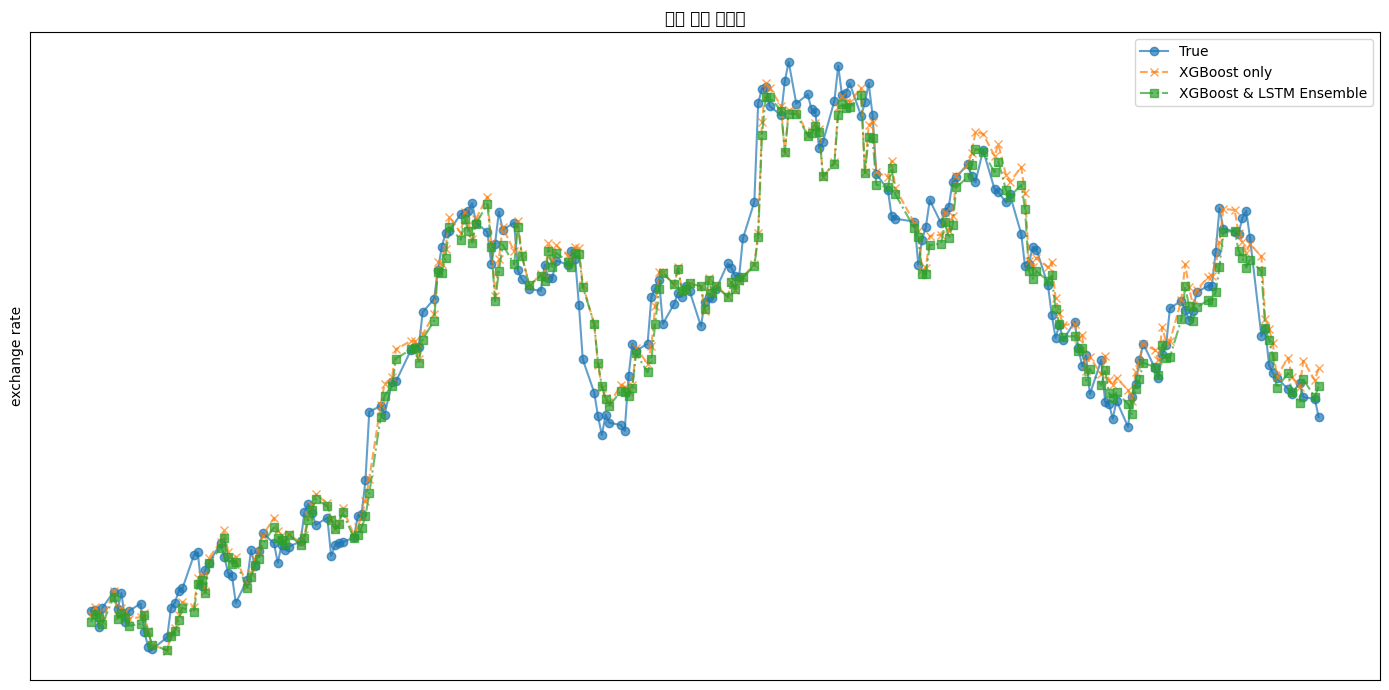

In [ ]:
# 6. 그래프

import matplotlib.pyplot as plt

# 시각화 함수 정의 (축 값 제거 추가)
def plot_three_results_no_ticks(dates, original, xgb_pred, blend_pred, title="모델 비교 시각화"):
    """
    원본 데이터, XGBoost 예측값, 앙상블 결과를 비교하는 꺾은선 그래프 생성 (축 값 제거).

    Args:
        dates (array-like): 날짜 데이터
        original (array-like): 실제 값 (원본 데이터)
        xgb_pred (array-like): XGBoost 예측값
        blend_pred (array-like): 앙상블 예측값
        title (str): 그래프 제목
    """

    plt.figure(figsize=(14, 7))
    plt.plot(dates, original, label="True", marker='o', linestyle='-', alpha=0.7)
    plt.plot(dates, xgb_pred, label="XGBoost only", marker='x', linestyle='--', alpha=0.7)
    plt.plot(dates, blend_pred, label="XGBoost & LSTM Ensemble", marker='s', linestyle='-.', alpha=0.7)
    plt.xlabel("")  # X축 제목 제거
    plt.ylabel("exchange rate")  # Y축 제목 제거
    plt.title(title)
    plt.xticks([])  # X축 값 제거
    plt.yticks([])  # Y축 값 제거
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 그래프 생성
plot_three_results_no_ticks(
    dates=dates,
    original=original,
    xgb_pred=xgb_pred,
    blend_pred=blend_pred,

)
